## Baseline Model for Subtask 1

In [13]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/shivampatel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/shivampatel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/shivampatel/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/shivampatel/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shivampatel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [14]:
# SVM baseline for SemEval-2020 Subtask-1

np.random.seed(500)

path =  '../data/raw/SemEval-2020-Task5-Dataset/Subtask-1/subtask1_train.csv'
corpus = pd.read_csv(path, encoding='utf-8')
percent = 0.3 	# 0.3 for testing
print("File: %s" % path)

corpus['sentence'].dropna(inplace=True)
corpus['sentence'] = [sent.lower() for sent in corpus['sentence']]
corpus['sentence'] = [word_tokenize(word) for word in corpus['sentence']]
tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
for index, entry in enumerate(corpus['sentence']):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
            Final_words.append(word_Final)
    corpus.loc[index, 'sentence_final'] = str(Final_words)
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(corpus['sentence_final'], corpus['gold_label'], test_size=percent)

print(">> Feature generation...")
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(corpus['sentence_final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

print(">> SVM classifier....")
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf, Train_Y)
predictions_SVM = SVM.predict(Test_X_Tfidf)
# print("SVM Accuracy Score -> ", accuracy_score(Test_Y, predictions_SVM) * 100)
print("SVM Precision Score -> ", precision_score(Test_Y, predictions_SVM) * 100)
print("SVM Recall Score -> ", recall_score(Test_Y, predictions_SVM) * 100)
print("SVM F1 Score -> ", f1_score(Test_Y, predictions_SVM) * 100)


File: ../data/raw/SemEval-2020-Task5-Dataset/Subtask-1/subtask1_train.csv
>> Feature generation...
>> SVM classifier....
SVM Precision Score ->  73.21428571428571
SVM Recall Score ->  8.951965065502183
SVM F1 Score ->  15.953307392996107


## Raw Data

In [6]:
train_df = pd.read_csv('../data/raw/SemEval-2020-Task5-Dataset/Subtask-1/subtask1_train.csv')

In [19]:
train_df.head()

,sentenceID,gold_label,sentence
0,100000,1,"Goodfellow's theory has been questioned, howev..."
1,100001,1,"However, both campaigners and pro-People's Vot..."
2,100002,1,Things could have been even better if the whol...
3,100003,0,"The new request, if approved, would keep the m..."
4,100004,0,Companies in financial difficulty can currentl...


In [18]:
list(train_df['sentence'])[:20]

["Goodfellow's theory has been questioned, however, because the plane made two other sharp turns that would've been impossible if the pilots were unconscious.",
 "However, both campaigners and pro-People's Vote MPs say that this number would be grow significantly if there were no other viable means of avoiding leaving the EU without a Withdrawal Agreement.",
 "Things could have been even better if the whole chip industry wasn't constrained by chip foundries such as Taiwan Semiconductor Manufacturing (NYSE: TSM) and United Microelectronics getting swamped under more orders than they can handle.",
 'The new request, if approved, would keep the military forces on the border through Jan.',
 'Companies in financial difficulty can currently only negotiate down wages and conditions to below those established by the collective bargaining procedure if they have the approval of unions, which is rarely given.',
 'If needed, I would like to have the right to try.',
 'In a REIT situation, the opera

## Label Imbalance

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
train_df.groupby('gold_label').count()

,sentenceID,sentence
gold_label,,
0,11546,11546
1,1454,1454


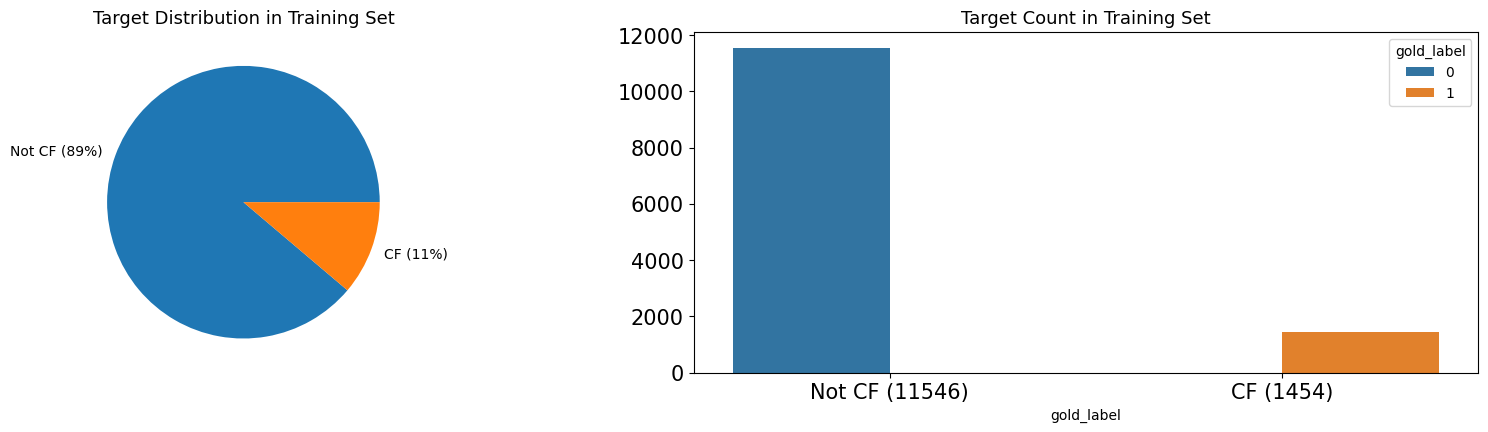

In [28]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

train_df.groupby('gold_label').count()['sentenceID'].plot(kind='pie', ax=axes[0], labels=['Not CF (89%)', 'CF (11%)'])
sns.countplot(x=train_df['gold_label'], hue=train_df['gold_label'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not CF (11546)', 'CF (1454)'])
# axes[0].tick_params(axis='x', labelsize=15)
# axes[0].tick_params(axis='y', labelsize=15)
# axes[1].tick_params(axis='x', labelsize=15)
# axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

## GloVe coverage

In [7]:
glove_dir = '../data/external/glove.6B.300d.txt'

vocab = {}
with open(glove_dir, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        vocab[word] = vector
f.close()

print('Found %s word vectors.' %len(vocab))

Found 400001 word vectors.


In [15]:
all_sentences = [sen.lower() for sen in list(train_df['sentence'])]

In [12]:
found, total = 0, 0
for sen in all_sentences:
    words = word_tokenize(sen)
    for word in words:
        total += 1
        if word in vocab.keys():
            found += 1

print('Found GloVe embeddings for '+str(found)+' out of total '+str(total)+' tokens. Coverage is '+str(found*100/total)+'%')

Found GloVe embeddings for 482575 out of total 486722 tokens. Coverage is 99.14797358656482%


## Sentence Lengths

99.24615384615385% of the sentences are less than or equal to 100 words long.


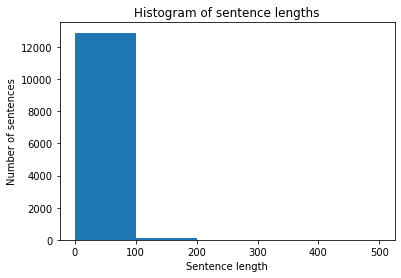

In [29]:
sen_lens = []
for sen in all_sentences:
    total += 1
    words = word_tokenize(sen)
    sen_lens.append(len(words))

print(str(len([x for x in sen_lens if x <= 100])*100.0/len(sen_lens))+'% of the sentences are less than or equal to 100 words long.')
    
plt.hist(sen_lens, bins = list(range(0, 600, 100))) 
plt.title("Histogram of sentence lengths")
plt.xlabel("Sentence length")
plt.ylabel("Number of sentences")
plt.show()